<a href="https://colab.research.google.com/github/MandisLoh/Keypoint_Detection/blob/main/Copy_of_Keypoint_and_Bounding_Box_Detection_using_PyTorch_Keypoint_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Keypoint and Bounding Box Detection using PyTorch Keypoint RCNN](https://debuggercafe.com/keypoint-and-bounding-box-detection-using-pytorch-keypoint-rcnn/)
![](https://debuggercafe.com/wp-content/uploads/2021/03/Keypoint-and-Bounding-Box-Detection-using-PyTorch-Keypoint-RCNN-e1614821149167.jpg)

## Setup and Downloading Data

In [ ]:
import requests
url = "https://drive.google.com/u/3/uc?id=1XfZnSBxU7crcYFeJJ3EUzZCOpi-GpYrf&export=download"
r = requests.get(url)
with open('input.zip', 'wb') as f:
    f.write(r.content)

# https://drive.google.com/file/d/1XfZnSBxU7crcYFeJJ3EUzZCOpi-GpYrf/view?usp=sharing

In [ ]:
!unzip /content/input.zip

Archive:  /content/input.zip
   creating: input/
  inflating: input/image_1.jpg       
 extracting: input/image_2.jpg       
  inflating: input/image_3.jpg       
  inflating: input/video_1.mp4       


In [ ]:
!mkdir outputs

In [ ]:
import matplotlib.pyplot as plt

from pylab import rcParams

rcParams['figure.figsize'] = 15, 12

def show_image(path):
    image = plt.imread(path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

## Utility Scripts

In [ ]:
%%writefile utils.py
import cv2
import matplotlib
import numpy

# pairs of edges for 17 of the keypoints detected ...
# ... these show which points to be connected to which point ...
# ... we can omit any of the connecting points if we want, basically ...
# ... we can easily connect less than or equal to 17 pairs of points ...
# ... for keypoint RCNN, not  mandatory to join all 17 keypoint pairs
edges = [
    (0, 1), (0, 2), (2, 4), (1, 3), (6, 8), (8, 10),
    (5, 7), (7, 9), (5, 11), (11, 13), (13, 15), (6, 12),
    (12, 14), (14, 16), (5, 6)
]

def draw_keypoints_and_boxes(outputs, image):
    # the `outputs` is list which in-turn contains the dictionary
    for i in range(len(outputs[0]['keypoints'])):
        # get the detected keypoints
        keypoints = outputs[0]['keypoints'][i].cpu().detach().numpy()
        # get the detected bounding boxes
        boxes = outputs[0]['boxes'][i].cpu().detach().numpy()

        # proceed to draw the lines and bounding boxes
        if outputs[0]['scores'][i] > 0.9: # proceed if confidence is above 0.9
            keypoints = keypoints[:, :].reshape(-1, 3)
            for p in range(keypoints.shape[0]):
                # draw the keypoints
                cv2.circle(image, (int(keypoints[p, 0]), int(keypoints[p, 1])),
                            3, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
            # draw the lines joining the keypoints
            for ie, e in enumerate(edges):
                # get different colors for the edges
                rgb = matplotlib.colors.hsv_to_rgb([
                    ie/float(len(edges)), 1.0, 1.0
                ])
                rgb = rgb*255
                # join the keypoint pairs to draw the skeletal structure
                cv2.line(image, (int(keypoints[e, 0][0]), int(keypoints[e, 1][0])),
                        (int(keypoints[e, 0][1]), int(keypoints[e, 1][1])),
                        tuple(rgb), 2, lineType=cv2.LINE_AA)

            # draw the bounding boxes around the objects
            cv2.rectangle(image, (int(boxes[0]), int(boxes[1])), (int(boxes[2]), int(boxes[3])),
                          color=(0, 255, 0),
                          thickness=2)
        else:
            continue

    return image


Writing utils.py


## Keypoint RCNN Model

In [ ]:
%%writefile models.py
import torchvision

def get_model(min_size=800):
    # initialize the model
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True,
                                                                   num_keypoints=17,
                                                                   min_size=min_size)

    return model


Writing models.py


## Keypoint and Bounding Box Detection with PyTorch Keypoint RCNN in Images

In [ ]:
%%writefile keypoint_bbox_images.py
import torch
import numpy as np
import cv2
import argparse
import utils

from PIL import Image
from torchvision.transforms import transforms as transforms
from models import get_model

# construct the argument parser to parse the command line arguments
parser = argparse.ArgumentParser()
parser.add_argument('-i', '--input', required=True,
                    help='path to the input data')
args = vars(parser.parse_args())

# transform to convert the image to tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

# set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# load the modle on to the computation device and set to eval mode
model = get_model().to(device).eval()

image_path = args['input']
image = Image.open(image_path).convert('RGB')
# NumPy copy of the image for OpenCV functions
orig_numpy = np.array(image, dtype=np.float32)
# convert the NumPy image to OpenCV BGR format
orig_numpy = cv2.cvtColor(orig_numpy, cv2.COLOR_RGB2BGR) / 255.
# transform the image
image = transform(image)
# add a batch dimension
image = image.unsqueeze(0).to(device)

# get the detections, forward pass the image through the model
with torch.no_grad():
    outputs = model(image)

# draw the keypoints, lines, and bounding boxes
output_image = utils.draw_keypoints_and_boxes(outputs, orig_numpy)

# visualize the image
# cv2.imshow('Keypoint image', output_image)
# cv2.waitKey(0)
# rgb_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
# rgb_image *= 255.
# rgb_image = rgb_image.astype(np.uint8)
# pil_image = Image.fromarray(rgb_image)
# pil_image.show()

# set the save path
save_path = f"/content/outputs/{args['input'].split('/')[-1].split('.')[0]}.jpg"
cv2.imwrite(save_path, output_image*255.)

Writing keypoint_bbox_images.py


In [ ]:
!python keypoint_bbox_images.py --input /content/input/image_1.jpg

Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /root/.cache/torch/hub/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth
100% 226M/226M [00:04<00:00, 48.1MB/s]


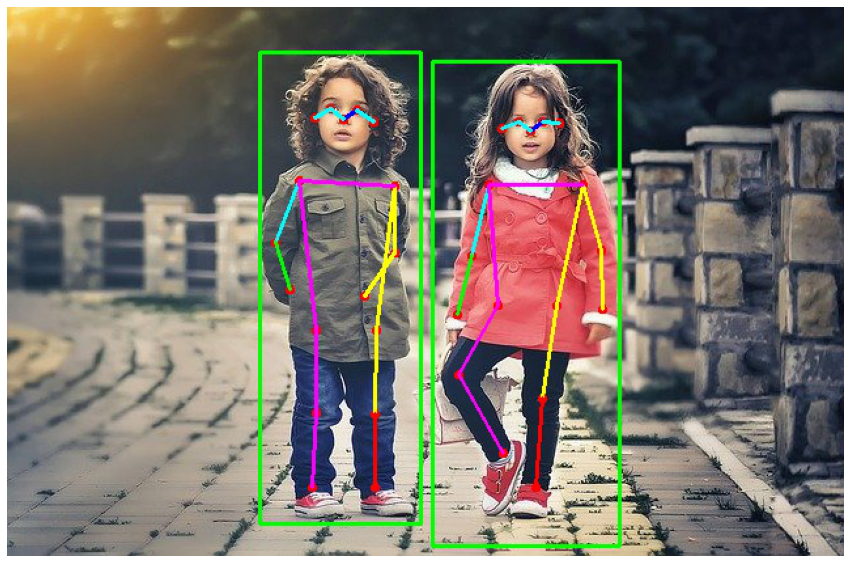

In [ ]:
show_image('/content/outputs/image_1.jpg')

In [ ]:
!python keypoint_bbox_images.py --input /content/input/image_2.jpg

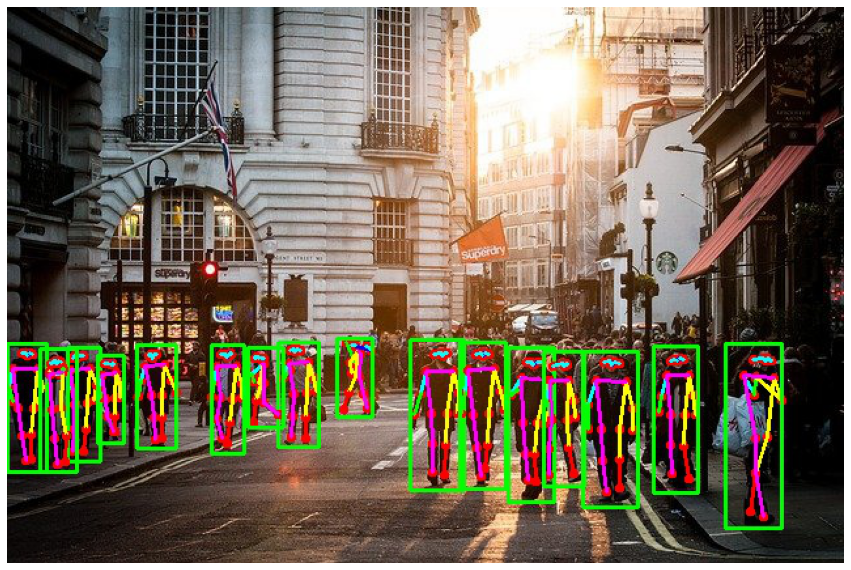

In [ ]:
show_image('/content/outputs/image_2.jpg')

In [ ]:
!python keypoint_bbox_images.py --input /content/input/image_3.jpg

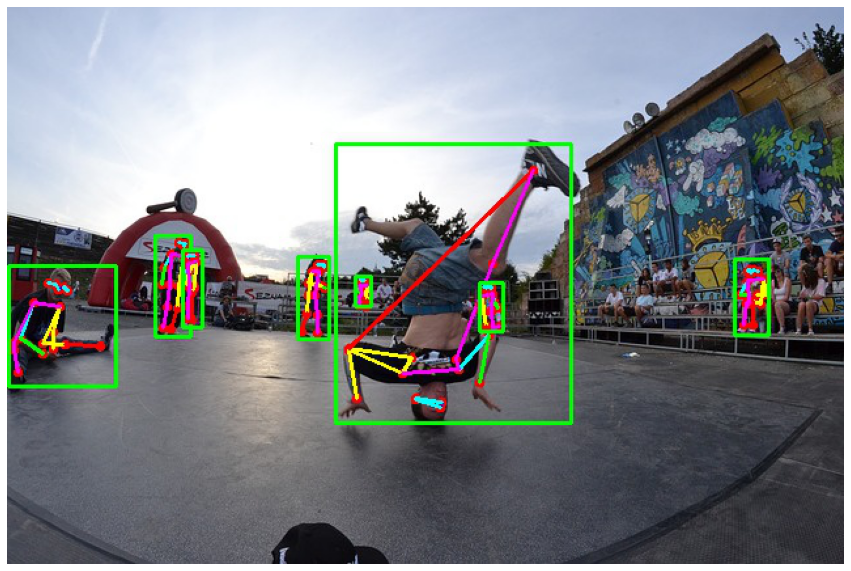

In [ ]:
show_image('/content/outputs/image_3.jpg')

## Keypoint and Bounding Box Detection with PyTorch Keypoint RCNN on Videos

### <font color="red">Visualizing videos on Colab is not well supported. You can carry inference here and download the outputs to visualize on you own systems. :)</font>

In [ ]:
%%writefile keypoint_bbox_videos.py
import torch
import cv2
import argparse
import utils
import time

from PIL import Image
from torchvision.transforms import transforms as transforms
from models import get_model

# construct the argument parser to parse the command line arguments
parser = argparse.ArgumentParser()
parser.add_argument('-i', '--input', required=True,
                    help='path to the input data')
parser.add_argument('-m', '--min-size', dest='min_size', default=800,
                    help='path to the input data')
args = vars(parser.parse_args())

# transform to convert the image to tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

# set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# load the modle on to the computation device and set to eval mode
model = get_model(min_size=args['min_size']).to(device).eval()

cap = cv2.VideoCapture(args['input'])
if (cap.isOpened() == False):
    print('Error while trying to read video. Please check path again')
# get the video frames' width and height
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# set the save path
save_path = f"/content/outputs/{args['input'].split('/')[-1].split('.')[0]}_{args['min_size']}.mp4"
# define codec and create VideoWriter object
out = cv2.VideoWriter(save_path,
                      cv2.VideoWriter_fourcc(*'mp4v'), 20,
                      (frame_width, frame_height))
frame_count = 0 # to count total frames
total_fps = 0 # to get the final frames per second

# read until end of video
while(cap.isOpened()):
    # capture each frame of the video
    ret, frame = cap.read()
    if ret == True:

        pil_image = Image.fromarray(frame).convert('RGB')
        orig_frame = frame

        # transform the image
        image = transform(pil_image)
        # add a batch dimension
        image = image.unsqueeze(0).to(device)

        # get the start time
        start_time = time.time()
        # get the detections, forward pass the frame through the model
        with torch.no_grad():
            outputs = model(image)

        # get the end time
        end_time = time.time()

        output_image = utils.draw_keypoints_and_boxes(outputs, orig_frame)

        # get the fps
        fps = 1 / (end_time - start_time)
        # add fps to total fps
        total_fps += fps
        # increment frame count
        frame_count += 1

        wait_time = max(1, int(fps/4))

        # cv2.imshow('Pose detection frame', output_image)
        out.write(output_image)
        print('Frame completed: ', fps, ' FPS')
        # press `q` to exit
        # if cv2.waitKey(wait_time) & 0xFF == ord('q'):
        #     break

    else:
        break

# release VideoCapture()
cap.release()
# close all frames and video windows
cv2.destroyAllWindows()
# calculate and print the average FPS
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")

Overwriting keypoint_bbox_videos.py


In [ ]:
!python keypoint_bbox_videos.py --input /content/input/PPFC_Cam1_3_Trim.mp4 --min-size 800

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=KeypointRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Frame completed:  0.47323899928827484  FPS
Frame completed:  4.4848073992889415  FPS
Frame completed:  4.73917125879491  FPS
Frame completed:  4.4303953371197755  FPS
Frame completed:  4.353534525261437  FPS
Frame completed:  4.69150500939016  FPS
Frame completed:  4.745079627616308  FPS
Frame completed:  4.699147514976467  FPS
Frame completed:  4

In [ ]:
import cv2
from sort import *

def save_cropped_images_with_tracking(video_path, detections):
    # Open the video file
    video = cv2.VideoCapture(video_path)

    frame_count = 0

    # Initialize the SORT tracker
    tracker = Sort()

    # Iterate through the detections for each frame
    while True:
        # Read the next frame from the video
        ret, frame = video.read()

        # Break the loop if no more frames are available
        if not ret:
            break

        # Get the detections for the current frame
        frame_detections = detections[frame_count]

        # Prepare the data for SORT tracker
        track_data = []
        for detection in frame_detections:
            bbox = detection['bbox']
            track_data.append(bbox)

        # Use the SORT tracker to associate and track the objects
        tracked_objects = tracker.update(np.array(track_data))

        # Iterate through the tracked objects
        for tracked_object in tracked_objects:
            object_id = int(tracked_object[4])  # Extract the object ID assigned by the tracker
            bbox = tracked_object[:4]  # Bounding box coordinates [x, y, width, height]

            # Extract the object region from the current frame
            x, y, w, h = bbox
            object_image = frame[y:y+h, x:x+w]

            # Generate a unique filename for each cropped image based on the frame index and object ID
            filename = f"frame_{frame_count}_object_{object_id}.jpg"

            # Save the cropped image
            cv2.imwrite(filename, object_image)

            # Display the saved image filename and corresponding bounding box coordinates
            print(f"Saved {filename} with bbox: {bbox}")

        frame_count += 1

    # Release the video object
    video.release()

# Example usage
video_path = '/content/output/BaleFire_Positive_TesterA_800.mp4'
detections = {
    0: [
        {
            'bbox': [100, 200, 150, 120],
            'keypoints': [...]
        },
        {
            'bbox': [300, 150, 200, 180],
            'keypoints': [...]
        },
        # Add more detections for frame 0 as necessary
    ],
    1: [
        # Detections for frame 1
    ],
    # Add detections for more frames as necessary
}

save_cropped_images_with_tracking(video_path, detections)


ImportError: ignored

In [ ]:
from google.colab import files

!zip -r /content/outputs outputs

files.download('outputs.zip')

  adding: outputs/ (stored 0%)
  adding: outputs/PPFC_Cam1_3_Trim_800.mp4 (deflated 2%)
  adding: outputs/BaleFire_Positive_TesterA_800.mp4 (deflated 2%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>